# TensorCircuit 中的 QuOperator

## 概述

`tensorcircuit.quantum.QuOperator`, `tensorcircuit.quantum.QuVector` 和 `tensorcircuit.quantum.QuAdjointVector` 是从 TensorNetwork 包中采用的类。
当与其他组件交互时，它们的行为类似于矩阵/向量（列或行），而内部结构由张量网络维护以提高效率和紧凑性。

QuOperator/QuVector 的典型张量网络结构对应于矩阵乘积运算符 (MPO) / 矩阵乘积状态 (MPS)。前者将矩阵表示为：
$M_{i1,i2,...in; \; j1, j2,... jn}=\prod_k {T_k}^{i_k, j_k}$,
即，$d\times d$ 矩阵 $T_k^{i_k, j_k}$ 的乘积，其中 $d$ 称为键维。类似地，MPS 将向量表示为：
$V_{i_1,...i_n} = \prod_k T_k^{i_k}$,
其中 $T_k^{i_k}$ 又是 $d\times d$ 矩阵。 MPS 和 MPO 经常出现在计算量子物理环境中，因为它们为某些类型的量子状态和算子提供了紧凑的表示。

``QuOperator``/``QuVector`` 对象可以表示任何 MPO/MPS，但它们还可以表示更灵活的张量网络结构。
实际上，任何具有两组相同维度的悬垂边的张量网络（即，对于每个 $k$，矩阵集 $\{T_k^{i_k,j_k}\}_{i_k,j_k}$ 具有 $i_k $ 和 $j_k$ 在同一个索引集上运行）
可以被视为“QuOperator”。一般的 QuVector 更加灵活，因为可以自由选择悬垂边的维度，因此可以表示任意向量的张量积。

在本笔记中，我们将展示这种张量网络后端矩阵/向量数据结构如何在多种场景中更加高效和紧凑，以及这些结构如何作为不同的电路成分与量子电路模拟任务无缝集成。

## 设置

In [1]:
import numpy as np
import tensornetwork as tn
import tensorcircuit as tc

print(tc.__version__)

0.0.220509


## QuOperator/QuVector 简介

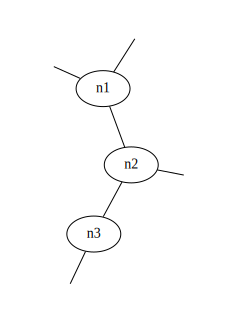

In [2]:
n1 = tc.gates.Gate(np.ones([2, 2, 2]), name="n1")
n2 = tc.gates.Gate(np.ones([2, 2, 2]), name="n2")
n3 = tc.gates.Gate(np.ones([2, 2]), name="n3")
# name 仅用于调试和可视化，可以省略
n1[2] ^ n2[2]
n2[1] ^ n3[0]

# 通过为行和列索引提供两组悬垂边来初始化 QuOperator
matrix = tc.quantum.QuOperator(out_edges=[n1[0], n2[0]], in_edges=[n1[1], n3[1]])
tn.to_graphviz(matrix.nodes)

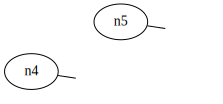

In [3]:
n4 = tc.gates.Gate(np.ones([2]), name="n4")
n5 = tc.gates.Gate(np.ones([2]), name="n5")

# 通过给出悬垂边来初始化 QuVector
vector = tc.quantum.QuVector([n4[0], n5[0]])
tn.to_graphviz(vector.nodes)

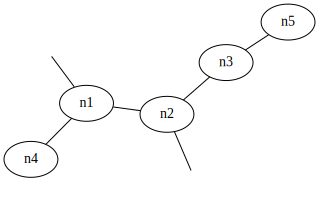

In [4]:
nvector = matrix @ vector
tn.to_graphviz(nvector.nodes)
# nvector 有两个悬垂边

In [5]:
assert type(nvector) == tc.quantum.QuVector

In [6]:
nvector.eval_matrix()

array([[16.],
       [16.],
       [16.],
       [16.]])

In [7]:
# 或者我们可以有更多类似矩阵/向量的操作
(3 * nvector).eval_matrix()

array([[48.],
       [48.],
       [48.],
       [48.]])

In [8]:
matrix.partial_trace([0]).eval_matrix()

array([[8., 8.],
       [8., 8.]])

注意在这个例子中，``matrix`` 不是一个典型的 MPO，但仍然可以表示为 ``QuOperator``。
事实上，任何具有两组相同维度的悬垂边的张量网络都可以被视为``QuOperator``。
``QuVector`` 更加灵活，因为我们可以将所有悬垂边视为向量维度。

另外，请注意 ``^`` 如何被重载为 ``tn.connect`` 以连接 TensorNetwork 中不同节点之间的边。
并且索引节点给出了节点的边，例如，``n1[0]`` 表示节点 ``n1`` 的第一条边。

定义 ``QuOperator`` 的约定是首先给出 ``out_edges``（矩阵的左索引或行索引），然后给出 ``in_edges``（矩阵的右索引或列索引）。
边列表包含来自 TensorNetwork 库的边对象。

这种 QuOperator/QuVector 抽象支持各种只能在矩阵/向量上进行的计算，例如 matmul (``@``)、伴随 (``.adjoint()``)、标量乘法 (``*``)、
张量积 （``|``）和部分跟踪（``.partial_trace(subsystems_to_trace_out)``）。
要提取这些对象的矩阵信息，我们可以使用 .eval() 或 .eval_matrix() ，前者保留张量网络的形状信息，后者给出带有形状秩的矩阵表示 2.

这里的工作流程也可以总结和可视化为 ![quop](../statics/quop.png)

## QuVector 作为电路的输入量子态

由于 QuVector 表现得像一个具有更紧凑表示的向量，我们可以以 QuVector 的形式而不是普通的 numpy 数组向量来提供电路输入状态。

In [9]:
# 这个例子展示了我们如何将 |111> 状态输入到电路中
n = 3
nodes = [tc.gates.Gate(np.array([0.0, 1.0])) for _ in range(n)]
mps = tc.quantum.QuVector([nd[0] for nd in nodes])
c = tc.Circuit(n, mps_inputs=mps)
c.x(0)
c.expectation_ps(z=[0])

array(1.+0.j)

## QuVector 作为电路的输出量子态

电路的张量网络表示可以看作是一个 ``QuVector``，即我们可以在真正收缩之前将电路作为一个向量来操作。这也是我们在内部进行电路组合的方式。

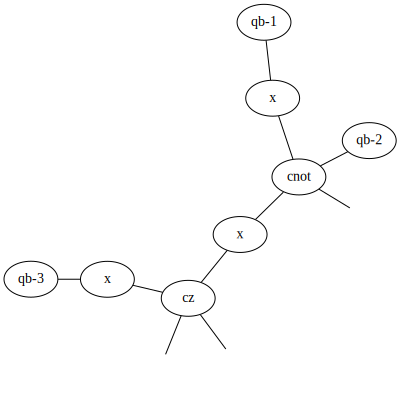

In [10]:
# 电路组合示例

n = 3
c1 = tc.Circuit(n)
c1.X(0)
c1.cnot(0, 1)
mps = c1.quvector()
c2 = tc.Circuit(n, mps_inputs=mps)
c2.X(2)
c2.X(1)
c2.cz(1, 2)
c2.expectation_ps(z=[1])
tn.to_graphviz(c2.get_quvector().nodes)

In [11]:
# 以上是电路组成的核心内部机制
# 用户 API 如下
n = 3
c1 = tc.Circuit(n)
c1.X(0)
c1.cnot(0, 1)

c2 = tc.Circuit(n)
c2.X(2)
c2.X(1)
c2.cz(1, 2)
c1.append(c2)

c1.draw()

┌───┐             
q_0: ┤ X ├──■──────────
     └───┘┌─┴─┐┌───┐   
q_1: ─────┤ X ├┤ X ├─■─
     ┌───┐└───┘└───┘ │ 
q_2: ┤ X ├───────────■─
     └───┘

## QuOperator 作为要在电路上评估的算子

对电路的输出状态进行评估的矩阵也可以用 QuOperator 来表示，这对于一些格点模型哈密顿量来说是非常强大和高效的。

In [12]:
# 这里我们展示一个最简单的模型，我们测量 <Z_0Z_1>

z0, z1 = tc.gates.z(), tc.gates.z()
mpo = tc.quantum.QuOperator([z0[0], z1[0]], [z0[1], z1[1]])
c = tc.Circuit(2)
c.X(0)
tc.templates.measurements.mpo_expectation(c, mpo)
# mpo 期望 API

-1.0

## QuOperator 作为应用于电路的量子门

由于量子门也是幺正矩阵，我们也可以将 QuOperator 用于量子门。
在某些情况下，量子门的 QuOperator 表示要紧凑得多，例如在多控制门情况下，相邻量子位的键维数可以减少到 2。

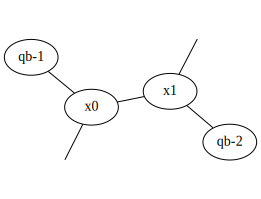

In [13]:
# 一般的 mpo 门 API 是 ``Circuit.mpo()``

x0, x1 = tc.gates.Gate(np.ones([2, 2, 3]), name="x0"), tc.gates.Gate(
    np.ones([2, 2, 3]), name="x1"
)
x0[2] ^ x1[2]
mpo = tc.quantum.QuOperator([x0[0], x1[0]], [x0[1], x1[1]])
c = tc.Circuit(2)
c.mpo(0, 1, mpo=mpo)
tn.to_graphviz(c._nodes)

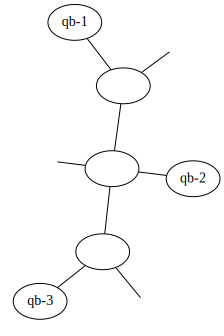

In [14]:
# 内置多控制门使用如下：

c = tc.Circuit(3)
c.multicontrol(0, 1, 2, ctrl=[0, 1], unitary=tc.gates.x())
tn.to_graphviz(c._nodes)

In [15]:
c.to_qir()[0]["gate"].nodes

{Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[[[0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j]]],
 
 
        [[[0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j]]]], dtype=complex64),
 edges : 
 [
 Edge('__unnamed_node__'[2] -> '__unnamed_node__'[0] )
 , 
 Edge(Dangling Edge)[1] 
 , 
 Edge(Dangling Edge)[2] 
 , 
 Edge('__unnamed_node__'[3] -> '__unnamed_node__'[0] )
 ] 
 ),
 Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[[1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j]],
 
        [[0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j]]], dtype=complex64),
 edges : 
 [
 Edge(Dangling Edge)[0] 
 , 
 Edge(Dangling Edge)[1] 
 , 
 Edge('__unnamed_node__'[2] -> '__unnamed_node__'[0] )
 ] 
 ),
 Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[[0.+0.j, 1.+0.j],
         [1.+0.j, 0.+0.j]],
 
        [[1.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j]]], dtype=complex64),
 edges : 


In [16]:
c.to_qir()[0]["gate"].eval_matrix()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]],
      dtype=complex64)